In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
pd.options.display.max_columns = None

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import itertools

In [2]:
# 그래프 한글 깨짐 방지
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)

In [3]:
df = pd.read_csv('./data/bikeshare.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,A,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 1:00,A,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 2:00,A,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 3:00,A,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 4:00,A,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00,D,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00,D,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00,D,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00,D,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00,D,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [5]:
df.shape

(10886, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 1020.7+ KB


In [7]:
# 날짜 데이터를 Timestamp 형식으로 변환
# 날짜 형식이 연, 월, 일, 시, 분, 초 형태일때

df['datetime'] = pd.to_datetime(df['datetime'])

In [8]:
# 13자리 숫자일 때
import datetime
timestamp = 1463460958000
datetimeobj = datetime.datetime.fromtimestamp(timestamp/1000)
print(datetimeobj, type(datetimeobj))

a = pd.to_datetime(datetimeobj)
print(a, type(a))

2016-05-17 13:55:58 <class 'datetime.datetime'>
2016-05-17 13:55:58 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
# datetime to timestamp
import time
timestamp = time.mktime(datetimeobj.timetuple())
timestamp

1463460958.0

In [10]:
import datetime
datetime.date(year=2019, month=10, day=1)

datetime.date(2019, 10, 1)

날짜 데이터로부터 연, 월, 일, 시, 요일 데이터 추출

In [11]:
df['year'] = df['datetime'].map(lambda x:x.year)
df['month'] = df['datetime'].map(lambda x:x.month)
df['day'] = df['datetime'].map(lambda x:x.day)
df['hour'] = df['datetime'].map(lambda x:x.hour)
df['dayofweek'] = df['datetime'].map(lambda x:x.dayofweek)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,A,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,A,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,A,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,A,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,A,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


날짜 데이터를 시 기준으로 그룹핑 (다른 데이터는 평균값 계산) 후 인덱스로 설정

In [12]:
df = df.groupby(['year', 'month','day', 'hour'])['temp', 'humidity', 'windspeed', 'count'].mean().reset_index()

C:\Users\wagar\AppData\Local\Temp\ipykernel_37660\321129136.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['year', 'month','day', 'hour'])['temp', 'humidity', 'windspeed', 'count'].mean().reset_index()


In [13]:
df.head()

,year,month,day,hour,temp,humidity,windspeed,count
0,2011,1,1,0,9.84,81.0,0.0,16.0
1,2011,1,1,1,9.02,80.0,0.0,40.0
2,2011,1,1,2,9.02,80.0,0.0,32.0
3,2011,1,1,3,9.84,75.0,0.0,13.0
4,2011,1,1,4,9.84,75.0,0.0,1.0


In [14]:
# 다시 date 컬럼 만들기
df['date'] = df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + df['day'].astype('str') + '-' + df['hour'].astype('str')

#date 컬럼 형식 변경 -> datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d-%H')

In [15]:
df = df.set_index('date')
df.head()

,year,month,day,hour,temp,humidity,windspeed,count
date,,,,,,,,
2011-01-01 00:00:00,2011,1,1,0,9.84,81.0,0.0,16.0
2011-01-01 01:00:00,2011,1,1,1,9.02,80.0,0.0,40.0
2011-01-01 02:00:00,2011,1,1,2,9.02,80.0,0.0,32.0
2011-01-01 03:00:00,2011,1,1,3,9.84,75.0,0.0,13.0
2011-01-01 04:00:00,2011,1,1,4,9.84,75.0,0.0,1.0


In [16]:
# 필요 컬럼만 선택
df = df[['temp', 'humidity', 'windspeed', 'count']]
df.head()

,temp,humidity,windspeed,count
date,,,,
2011-01-01 00:00:00,9.84,81.0,0.0,16.0
2011-01-01 01:00:00,9.02,80.0,0.0,40.0
2011-01-01 02:00:00,9.02,80.0,0.0,32.0
2011-01-01 03:00:00,9.84,75.0,0.0,13.0
2011-01-01 04:00:00,9.84,75.0,0.0,1.0


In [17]:
# 시계열용 데이터는 따로 뺴둠
dfts = pd.DataFrame(df['count'])

In [18]:
dfts

,count
date,
2011-01-01 00:00:00,16.0
2011-01-01 01:00:00,40.0
2011-01-01 02:00:00,32.0
2011-01-01 03:00:00,13.0
2011-01-01 04:00:00,1.0
...,...
2012-12-19 19:00:00,336.0
2012-12-19 20:00:00,241.0
2012-12-19 21:00:00,168.0


y값 이외에 독립변수가 더 있을 경우

데이터 타입 맞춰주기

In [19]:
df.columns

Index(['temp', 'humidity', 'windspeed', 'count'], dtype='object')

In [20]:
col_id = []
col_cat = []
col_int = []
col_float = ['temp', 'humidity', 'windspeed', 'count']
col_bool = []
col_num = col_int + col_float

df[col_cat] = df[col_cat].astype('str')
df[col_int] = df[col_int].astype('int', errors='ignore')
df[col_float] = df[col_float].astype('float')

DQ Chechk (빈도 분석, 분포 분석)

연속형 변수

In [21]:
def DA(data):
    da = data.describe([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
    da = da.T
    df1 = data.isna().sum()
    df1.name = 'missing'
    df2 = data.median()
    df2.name = 'median'
    df3 = np.var(data)
    df3.name = 'variance'
    df4 = data.skew()
    df4.name = 'skewness'
    df5 = data.kurtosis()
    df5.name = 'kurtosis'
    
    da = pd.concat([da, df1, df2, df3, df4, df5], axis=1)
    da['total'] = da['count'] + da['missing']
    
    col_nm = da.columns.tolist()
    order = ['total', 'count', 'missing','mean','median', 'std', 'variance', 'skewness', 'kurtosis',
             'min', '5%', '10%', '25%','50%', '75%', '90%', '95%', 'max']
    
    col_nm_new = []
    for i in order : 
        col_nm_new.append(i)
        
    da = da[col_nm_new]
    da = da.round(2)
    return da

In [22]:
DA1 = DA(df[col_num])
DA1

,total,count,missing,mean,median,std,variance,skewness,kurtosis,min,5%,10%,25%,50%,75%,90%,95%,max
temp,10886.0,10886.0,0,20.23,20.5,7.79,60.70,0.00,-0.91,0.82,8.2,9.84,13.94,20.5,26.24,30.34,32.80,41.0
humidity,10886.0,10886.0,0,61.89,62.0,19.25,370.34,-0.09,-0.76,0.00,31.0,37.00,47.00,62.0,77.00,88.00,93.00,100.0
windspeed,10886.0,10886.0,0,12.80,13.0,8.16,66.65,0.59,0.63,0.00,0.0,0.00,7.00,13.0,17.00,24.00,28.00,57.0
count,10886.0,10886.0,0,191.57,145.0,181.14,32810.30,1.24,1.30,1.00,5.0,9.00,42.00,145.0,284.00,452.00,563.75,977.0


범주형 변수

In [23]:
def DA_cat(data, col_cat):
    DA_cat = pd.DataFrame()
    
    for i in col_cat:
        a = data[i].value_counts(dropna=False).to_frame().sort_index().rename(columns={i:'count'}).reset_index()
        a['col_nm'] = i
        a = a.rename(columns={'index':'class'})
        a = a[['col_nm', 'class', 'count']]
        
        b = data[i].value_counts(dropna=False, normalize=True).to_frame().sort_index().rename(columns={i:'ratio'}).reset_index()
        b = b['ratio'].to_frame()
        
        c = pd.concat([a,b], axis=1)
        DA_cat = pd.concat([DA_cat,c], axis=0)
        
    DA_cat = DA_cat.reset_index(drop=True)
    return DA_cat

In [24]:
DA2 = DA_cat(df, col_cat+col_bool)
DA2

""


전처리 (중복값, 결측치, 이상치 처리)

중복값

In [25]:
df[df.duplicated(keep=False)].sort_values(['temp','humidity', 'windspeed','count'])

,temp,humidity,windspeed,count
date,,,,
2012-01-04 02:00:00,0.82,34.0,19.0012,1.0
2012-01-04 03:00:00,0.82,34.0,19.0012,1.0
2011-01-09 04:00:00,3.28,53.0,12.9980,1.0
2011-01-09 05:00:00,3.28,53.0,12.9980,1.0
2011-02-10 05:00:00,4.92,50.0,15.0013,6.0
...,...,...,...,...
2012-08-08 03:00:00,28.70,84.0,0.0000,7.0
2012-08-08 04:00:00,28.70,84.0,0.0000,7.0
2011-08-07 05:00:00,28.70,89.0,12.9980,5.0


In [26]:
df.drop_duplicates()

,temp,humidity,windspeed,count
date,,,,
2011-01-01 00:00:00,9.84,81.0,0.0000,16.0
2011-01-01 01:00:00,9.02,80.0,0.0000,40.0
2011-01-01 02:00:00,9.02,80.0,0.0000,32.0
2011-01-01 03:00:00,9.84,75.0,0.0000,13.0
2011-01-01 04:00:00,9.84,75.0,0.0000,1.0
...,...,...,...,...
2012-12-19 19:00:00,15.58,50.0,26.0027,336.0
2012-12-19 20:00:00,14.76,57.0,15.0013,241.0
2012-12-19 21:00:00,13.94,61.0,15.0013,168.0


In [27]:
df.isna().sum()

temp         0
humidity     0
windspeed    0
count        0
dtype: int64

In [28]:
# na처리 
df.dropna() # nan이 하나라도 들어간 행은 삭제
df.dropna(how='all') # 데이터가 모두 nan인 행만 삭제 / 초기값 : any

df.fillna(0) # na를 0으로 채우기

new_data = {'a':0, 'b':1, 'c':-999}
df.fillna(new_data)  # na 발생 시 a 열에는 0, b 열에는 1, c열에는 -999로 채움
df.fillna(new_data, limit=2)    # 각 열별로 2개의  nan까지 대체
df.fillna(method = 'ffill')     # 열 별로 바로 앞의 데이터로 채움
df.fillna(method = 'bfill')     # 열 별로 바로 뒤의 데이터로 채움
# ffill의 경우 첫 행이거나 앞의 데이터가 nan일 경우 nan 유지, bfill도 동일

# 평균값, 중앙값으로 대치
#df.loc[19, 'Leaflets'] = df['Leaflets'].mean()
#df.loc[19, 'Leaflets'] = df['Leaflets'].median

,temp,humidity,windspeed,count
date,,,,
2011-01-01 00:00:00,9.84,81.0,0.0000,16.0
2011-01-01 01:00:00,9.02,80.0,0.0000,40.0
2011-01-01 02:00:00,9.02,80.0,0.0000,32.0
2011-01-01 03:00:00,9.84,75.0,0.0000,13.0
2011-01-01 04:00:00,9.84,75.0,0.0000,1.0
...,...,...,...,...
2012-12-19 19:00:00,15.58,50.0,26.0027,336.0
2012-12-19 20:00:00,14.76,57.0,15.0013,241.0
2012-12-19 21:00:00,13.94,61.0,15.0013,168.0


<AxesSubplot:xlabel='windspeed'>

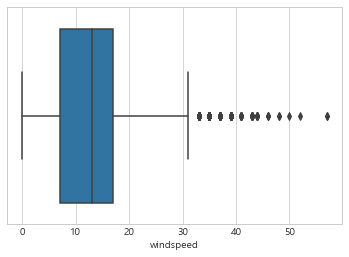

In [29]:
tmp = 'windspeed'
sns.boxplot(x=tmp, data=df, orient='h')

In [30]:
# IQR 활용
q1 = df[tmp].quantile(.25)
q3 = df[tmp].quantile(.75)
iqr = q3 - q1

min_iqr = q1 - 1.5*iqr
max_iqr = q3 + 1.5*iqr

min_from_all = df[tmp].min()
max_from_all = df[tmp].max()

if (min_iqr < min_from_all):
    min_iqr = min_from_all
    
if (max_iqr > max_from_all):
    max_iqr = max_from_all
    
outlier = df[(df[tmp] < min_iqr) | (df[tmp] > max_iqr)]     #  이상치 조회
outlier_index = outlier.index
print(outlier.shape)
outlier

(227, 4)


,temp,humidity,windspeed,count
date,,,,
2011-01-08 14:00:00,8.20,32.0,32.9975,95.0
2011-01-08 17:00:00,6.56,37.0,36.9974,69.0
2011-01-09 09:00:00,4.92,46.0,35.0008,19.0
2011-01-09 11:00:00,6.56,40.0,35.0008,49.0
2011-01-12 12:00:00,8.20,47.0,39.0007,55.0
...,...,...,...,...
2012-11-02 14:00:00,16.40,40.0,32.9975,262.0
2012-11-08 12:00:00,16.40,24.0,32.9975,235.0
2012-11-13 01:00:00,18.04,88.0,43.0006,5.0


In [31]:
# min/max값으로 보정
df.loc[(df[tmp] < min_iqr), tmp] = min_iqr  # 이상치 보정 - 하한치로 보정
df.loc[(df[tmp] > max_iqr), tmp] = max_iqr  # 이상치 보정 - 상한치로 보정

In [32]:
# 이상치 제거
df = df.drop(outlier_index, axis=0)
df.shape

(10659, 4)

파생 변수 생성

In [33]:
today = pd.to_datetime('2020-12-13')

In [34]:
# Recency
cond1 = (today - df.index) >= pd.Timedelta('3000 days')
cond2 = ((today - df.index) < pd.Timedelta('3000 days')) & ((today - df.index) >= pd.Timedelta('2000 days'))
cond3 = (today - df.index) < pd.Timedelta('2000 days')

df.loc[cond1, 'Recency'] = 1
df.loc[cond2, 'Recency'] = 2
df.loc[cond3, 'Recency'] = 3

In [35]:
# Frequency
df.loc[df['count'] <= 10, 'Frequency'] = 1
df.loc[(df['count'] > 10) & (df['count'] <= 20), 'Frequency'] = 2
df.loc[df['count'] > 20, 'Frequency'] = 3

In [36]:
# Monetary
df['Monetary'] = df['count'] * df['temp']

In [37]:
df.head()

,temp,humidity,windspeed,count,Recency,Frequency,Monetary
date,,,,,,,
2011-01-01 00:00:00,9.84,81.0,0.0,16.0,1.0,2.0,157.44
2011-01-01 01:00:00,9.02,80.0,0.0,40.0,1.0,3.0,360.80
2011-01-01 02:00:00,9.02,80.0,0.0,32.0,1.0,3.0,288.64
2011-01-01 03:00:00,9.84,75.0,0.0,13.0,1.0,2.0,127.92
2011-01-01 04:00:00,9.84,75.0,0.0,1.0,1.0,1.0,9.84


In [38]:
df

,temp,humidity,windspeed,count,Recency,Frequency,Monetary
date,,,,,,,
2011-01-01 00:00:00,9.84,81.0,0.0000,16.0,1.0,2.0,157.44
2011-01-01 01:00:00,9.02,80.0,0.0000,40.0,1.0,3.0,360.80
2011-01-01 02:00:00,9.02,80.0,0.0000,32.0,1.0,3.0,288.64
2011-01-01 03:00:00,9.84,75.0,0.0000,13.0,1.0,2.0,127.92
2011-01-01 04:00:00,9.84,75.0,0.0000,1.0,1.0,1.0,9.84
...,...,...,...,...,...,...,...
2012-12-19 19:00:00,15.58,50.0,26.0027,336.0,2.0,3.0,5234.88
2012-12-19 20:00:00,14.76,57.0,15.0013,241.0,2.0,3.0,3557.16
2012-12-19 21:00:00,13.94,61.0,15.0013,168.0,2.0,3.0,2341.92


데이터 마트 DQ Check, 변수 선택 및 EDA

In [39]:
df.columns

Index(['temp', 'humidity', 'windspeed', 'count', 'Recency', 'Frequency',
       'Monetary'],
      dtype='object')

In [40]:
col_num = ['temp', 'humidity','windspeed','count','Monetary']
col_cat = ['Recency', 'Frequency']
DA3 = DA(df[col_num])
DA3

,total,count,missing,mean,median,std,variance,skewness,kurtosis,min,5%,10%,25%,50%,75%,90%,95%,max
temp,10659.0,10659.0,0,20.27,20.5,7.79,60.65,-0.00,-0.91,0.82,8.20,9.84,13.94,20.5,26.24,30.34,32.80,41.00
humidity,10659.0,10659.0,0,62.21,62.0,19.08,364.15,-0.09,-0.76,0.00,32.00,37.00,47.00,62.0,78.00,88.00,93.00,100.00
windspeed,10659.0,10659.0,0,12.29,11.0,7.44,55.36,0.23,-0.37,0.00,0.00,0.00,7.00,11.0,17.00,22.00,26.00,31.00
count,10659.0,10659.0,0,191.56,145.0,181.21,32834.49,1.24,1.29,1.00,5.00,9.00,42.00,145.0,285.00,453.00,563.00,977.00
Monetary,10659.0,10659.0,0,4435.16,2640.4,5020.56,25203704.77,1.66,2.88,0.82,63.96,139.40,610.08,2640.4,6519.82,11635.80,15150.65,30157.14


In [42]:
DA4 = DA_cat(df, col_cat)
DA4

,col_nm,class,count,ratio
0,Recency,1.0,9301,0.872596
1,Recency,2.0,1358,0.127404
2,Frequency,1.0,1209,0.113425
3,Frequency,2.0,624,0.058542
4,Frequency,3.0,8826,0.828033


In [43]:
df = df.drop(columns=['Recency'], axis=1)

<AxesSubplot:xlabel='date', ylabel='temp'>

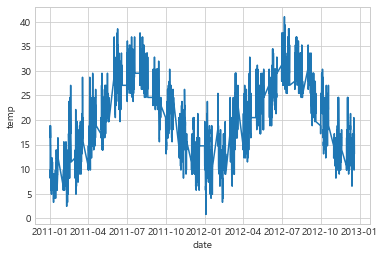

In [48]:
# 범주형 x 별 y의 평균
sns.lineplot(x=df.index, y='temp',data=df)

<AxesSubplot:xlabel='temp', ylabel='count'>

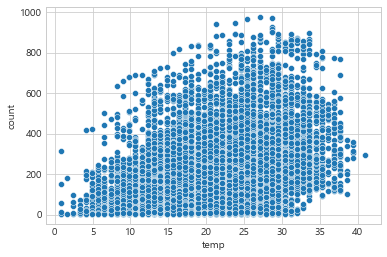

In [49]:
sns.scatterplot(x='temp', y='count', data=df)

종속 변수 분포 확인 및 전처리

<AxesSubplot:ylabel='Frequency'>

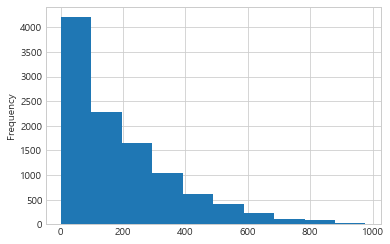

In [50]:
df['count'].plot(kind='hist')

In [51]:
df['y2'] = np.log1p(df['count'])

<AxesSubplot:ylabel='Frequency'>

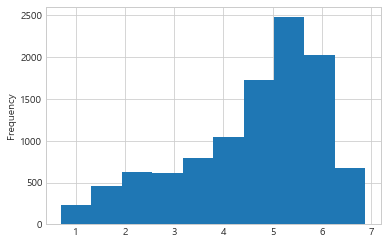

In [52]:
df['y2'].plot(kind='hist')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10659 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       10659 non-null  float64
 1   humidity   10659 non-null  float64
 2   windspeed  10659 non-null  float64
 3   count      10659 non-null  float64
 4   Frequency  10659 non-null  float64
 5   Monetary   10659 non-null  float64
 6   y2         10659 non-null  float64
dtypes: float64(7)
memory usage: 666.2 KB


In [54]:
df.head()

,temp,humidity,windspeed,count,Frequency,Monetary,y2
date,,,,,,,
2011-01-01 00:00:00,9.84,81.0,0.0,16.0,2.0,157.44,2.833213
2011-01-01 01:00:00,9.02,80.0,0.0,40.0,3.0,360.80,3.713572
2011-01-01 02:00:00,9.02,80.0,0.0,32.0,3.0,288.64,3.496508
2011-01-01 03:00:00,9.84,75.0,0.0,13.0,2.0,127.92,2.639057
2011-01-01 04:00:00,9.84,75.0,0.0,1.0,1.0,9.84,0.693147


In [58]:
import statsmodels.api as sm
from patsy import dmatrices
y, X = dmatrices('y2 ~ temp + humidity + windspeed + Frequency +Monetary', data=df, return_type='dataframe')

VIF 확인 (y값 안섞이게 주의)

In [59]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features']  = X.columns
vif

,VIF Factor,features
0,47.966320,Intercept
1,1.568157,temp
2,1.247653,humidity
3,1.104879,windspeed
4,1.181337,Frequency
5,1.863814,Monetary


In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [62]:
# 컬럼명 다시 붙여주기
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

군집화

In [63]:
from sklearn.cluster import KMeans

def elbow(X):
    sse = []
    for i in range(1,11):
        km = KMeans(n_clusters= i, init='k-means++', random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('n_clusters')
    plt.ylabel('SSE')
    plt.show()

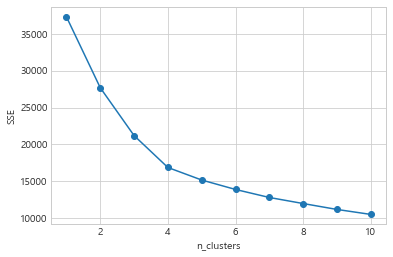

In [64]:
elbow(X_train_scaled)

In [69]:
from sklearn.metrics import silhouette_samples, silhouette_score

def sil(X):
    si = []
    for i in range(2,11):
        km = KMeans(n_clusters=i, init='k-means++', random_state=0)
        km.fit(X)
        si.append(silhouette_score(X, km.labels_))
        
    print(np.round(si,3))
    
sil(X_train_scaled)

[0.239 0.279 0.279 0.248 0.237 0.231 0.22  0.217 0.217]


군집 수 직접 지정해서 군집화

In [70]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=4, random_state=0)

군집화 결과 프로파일링

In [71]:
# 스케일링 풀고 프로파일링

df_profile = pd.DataFrame(scaler.inverse_transform(X_train_scaled), columns=X_train.columns)
df_profile['kmeans'] = kmeans.labels_

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='kmeans', ylabel='windspeed'>

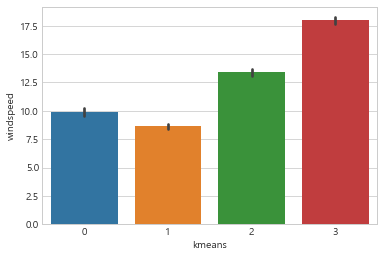

In [72]:
sns.barplot(df_profile['kmeans'], df_profile['windspeed'])

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='kmeans', ylabel='Monetary'>

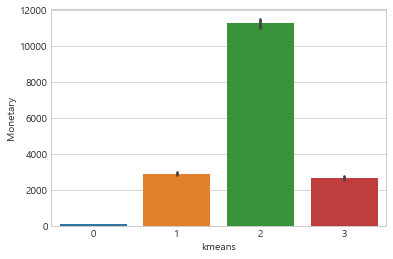

In [73]:
sns.barplot(df_profile['kmeans'], df_profile['Monetary'])

군집화 결과를 새로운 컬럼으로 추가

In [74]:
X_train_scaled['kmeans'] = kmeans.labels_

kmeans_test = kmeans.predict(X_test_scaled)
X_test_scaled['kmeans'] = kmeans_test

In [75]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [76]:
models = []
models.append(('Ridge', Ridge()))
models.append(('Lasso',Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('Huber', HuberRegressor()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('KernelRidge', KernelRidge()))
models.append(('MLP', MLPRegressor()))
models.append(('SVR', SVR()))

models

[('Ridge', Ridge()),
 ('Lasso', Lasso()),
 ('ElasticNet', ElasticNet()),
 ('Huber', HuberRegressor()),
 ('DT', DecisionTreeRegressor()),
 ('KNN', KNeighborsRegressor()),
 ('KernelRidge', KernelRidge()),
 ('MLP', MLPRegressor()),
 ('SVR', SVR())]

In [77]:
num_folds = 5
seed = 7

names = []
results = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for name, model in models:
    score = cross_val_score(model, X_train_scaled, y_train.values.ravel(), cv=kfold)
    names.append(name)
    results.append(score)
    print(name, score.mean().round(5))

Ridge 0.88593
Lasso 0.17775
ElasticNet 0.57264
Huber 0.88326
DT 0.99869
KNN 0.9561
KernelRidge -0.13894


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP 0.98547
SVR 0.97468


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


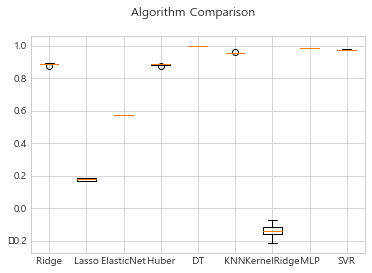

In [78]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

파라미터 튜닝 및 최종 모델 선택

In [79]:
model = RandomForestRegressor()

n_estimators_set = [50, 60, 70, 80, 90,100]
max_features_set = [6,7,8,9,10]
param_grid = dict(n_estimators=n_estimators_set,
                  max_features = max_features_set)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train.values.ravel())
print('Best %f using %s' %(grid_result.best_score_, grid_result.best_params_))

a = grid_result.cv_results_

for i in range(len(a['rank_test_score'])):
    print('%f (%f) with %r' %(a['mean_test_score'][i], a['std_test_score'][i], a['params'][i]))

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\parallel.py

Best 0.999416 using {'max_features': 7, 'n_estimators': 50}
0.999310 (0.000262) with {'max_features': 6, 'n_estimators': 50}
0.999339 (0.000261) with {'max_features': 6, 'n_estimators': 60}
0.999351 (0.000271) with {'max_features': 6, 'n_estimators': 70}
0.999331 (0.000291) with {'max_features': 6, 'n_estimators': 80}
0.999350 (0.000280) with {'max_features': 6, 'n_estimators': 90}
0.999316 (0.000308) with {'max_features': 6, 'n_estimators': 100}
0.999416 (0.000301) with {'max_features': 7, 'n_estimators': 50}
0.999352 (0.000344) with {'max_features': 7, 'n_estimators': 60}
0.999401 (0.000291) with {'max_features': 7, 'n_estimators': 70}
0.999393 (0.000332) with {'max_features': 7, 'n_estimators': 80}
0.999380 (0.000305) with {'max_features': 7, 'n_estimators': 90}
0.999395 (0.000303) with {'max_features': 7, 'n_estimators': 100}
nan (nan) with {'max_features': 8, 'n_estimators': 50}
nan (nan) with {'max_features': 8, 'n_estimators': 60}
nan (nan) with {'max_features': 8, 'n_estimators

In [80]:
fine_tuned_RF = grid_result.best_estimator_
print('best_params : ', grid_result.best_params_)
fine_tuned_RF.feature_importances_

best_params :  {'max_features': 7, 'n_estimators': 50}


array([0.00000000e+00, 3.11881225e-02, 1.55534450e-04, 1.17918342e-04,
       1.12877537e-01, 8.55651337e-01, 9.55124917e-06])

In [81]:
pd.DataFrame({'col':X_train_scaled.columns, 'F1': fine_tuned_RF.feature_importances_}).sort_values('F1',ascending=False)

,col,F1
5,Monetary,0.855651
4,Frequency,0.112878
1,temp,0.031188
2,humidity,0.000156
3,windspeed,0.000118
6,kmeans,0.000010
0,Intercept,0.000000


<AxesSubplot:>

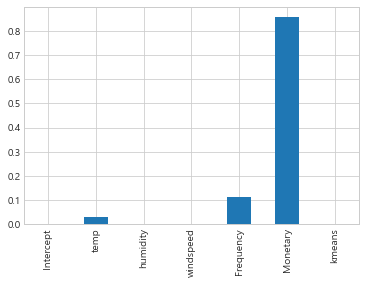

In [82]:
importances = pd.Series(fine_tuned_RF.feature_importances_, index=X_train_scaled.columns)
importances.plot(kind='bar')

Test Set 활용하여 예측 수행

In [85]:
y_pred = fine_tuned_RF.predict(X_test_scaled)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

# MAPE
def mp(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs(y_test - y_pred) / y_test) * 100

mape = mp(np.expm1(y_test), np.expm1(y_pred))

print('r2 : ', r2)
print('mse : ', mse)
print('rmse : ', rmse)
print('mape : ', mape)

r2 :  0.9984117476488702
mse :  52.40222667091917
rmse :  7.238938228146388
mape :  762.197744918165


In [86]:
# 데이터를 2011년 8월 자료로만 줄임
data = dfts[(dfts.index.year == 2011) & (dfts.index.month==8)]
data.shape

(456, 1)

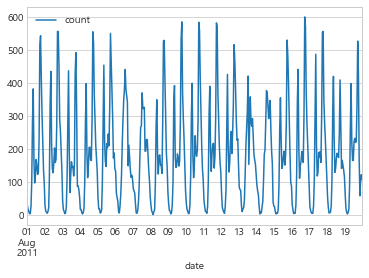

In [87]:
fig = data.plot()

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


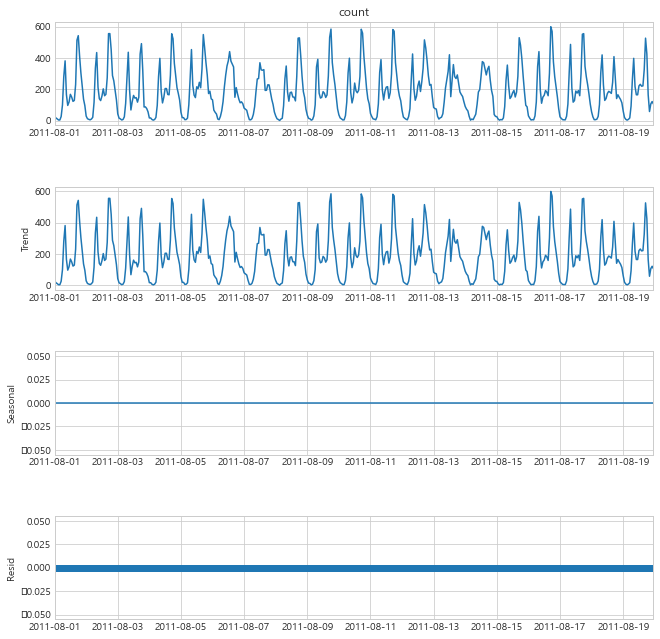

In [88]:
decomposition = sm.tsa.seasonal_decompose(data['count'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [89]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


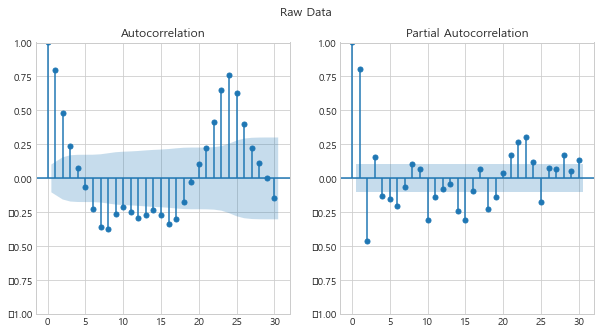

In [92]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Raw Data')

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax = ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax = ax[1])
plt.show()

ACF 그래프가 점진적으로 감소하는 것은 전형적인 None-Stationary 데이터이다. -> 즉, 정상성이 없음

In [93]:
# Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['count'].diff()
diff_train_data = diff_train_data.dropna()

print('----Raw data----')
print(train_data)

print('----Differenced Data----')
print(diff_train_data)

----Raw data----
                     count
date                      
2011-08-01 00:00:00   29.0
2011-08-01 01:00:00   17.0
2011-08-01 02:00:00   11.0
2011-08-01 03:00:00    4.0
2011-08-01 04:00:00    4.0
...                    ...
2011-08-15 23:00:00   88.0
2011-08-16 00:00:00   31.0
2011-08-16 01:00:00   16.0
2011-08-16 02:00:00    4.0
2011-08-16 03:00:00    6.0

[364 rows x 1 columns]
----Differenced Data----
date
2011-08-01 01:00:00   -12.0
2011-08-01 02:00:00    -6.0
2011-08-01 03:00:00    -7.0
2011-08-01 04:00:00     0.0
2011-08-01 05:00:00    22.0
                       ... 
2011-08-15 23:00:00   -10.0
2011-08-16 00:00:00   -57.0
2011-08-16 01:00:00   -15.0
2011-08-16 02:00:00   -12.0
2011-08-16 03:00:00     2.0
Name: count, Length: 363, dtype: float64


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


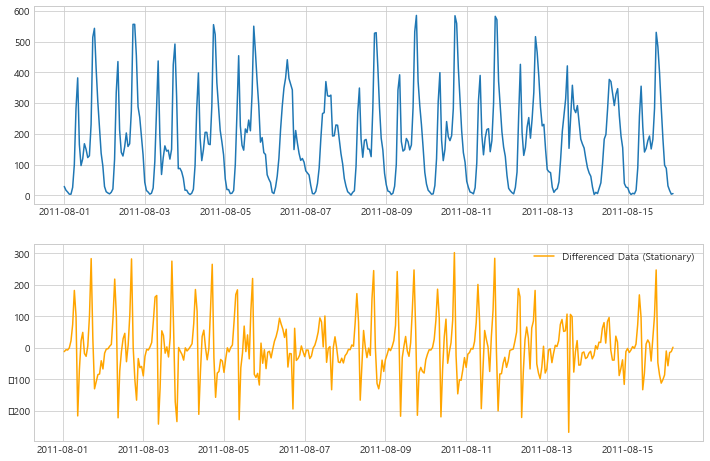

In [94]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['count'])

plt.subplot(212)
plt.plot(diff_train_data,'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


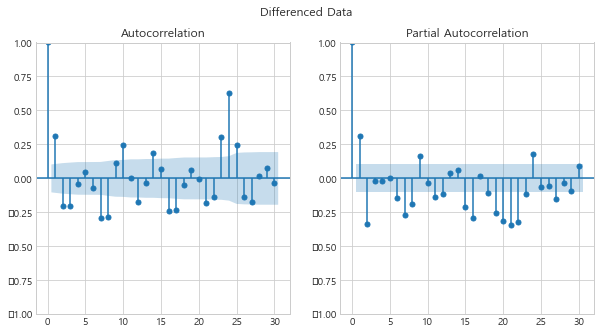

In [96]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Differenced Data')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])
plt.show()

기본 모델 생성

In [109]:
from statsmodels.tsa.arima.model import ARIMA

model = sm.tsa.arima.ARIMA(train_data.values, order=(1,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2122.750
Date:                Sun, 21 Aug 2022   AIC                           4251.501
Time:                        16:38:41   BIC                           4263.184
Sample:                             0   HQIC                          4256.145
                                - 364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1120      0.104     -1.076      0.282      -0.316       0.092
ma.L1          0.5537      0.097      5.735      0.000       0.364       0.743
sigma2      7023.6132    380.324     18.467      0.000    6278.193    7769.034
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                65.81
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.03
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
model = ARIMA(train_data.values, order=(0,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2123.377
Date:                Sun, 21 Aug 2022   AIC                           4250.754
Time:                        16:40:01   BIC                           4258.543
Sample:                             0   HQIC                          4253.850
                                - 364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4724      0.041     11.602      0.000       0.393       0.552
sigma2      7047.6759    361.804     19.479      0.000    6338.552    7756.799
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                73.53
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.12
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

최적 모델 탐색

In [111]:
print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
pdq

Examples of parameter combinations for Seasonal ARIMA...


[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [113]:
aic = []
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA : {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

ARIMA : (0, 1, 0) >> AIC : 4313.04
ARIMA : (0, 1, 1) >> AIC : 4250.75
ARIMA : (0, 1, 2) >> AIC : 4250.07
ARIMA : (1, 1, 0) >> AIC : 4277.77
ARIMA : (1, 1, 1) >> AIC : 4251.5
ARIMA : (1, 1, 2) >> AIC : 4196.09
ARIMA : (2, 1, 0) >> AIC : 4236.56
ARIMA : (2, 1, 1) >> AIC : 4238.4
ARIMA : (2, 1, 2) >> AIC : 4192.68


In [114]:
# Search optimal parameters

optimal = [(pdq[i], j) for i , j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 2), 4192.68)]

In [116]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2091.341
Date:                Sun, 21 Aug 2022   AIC                           4192.681
Time:                        16:45:00   BIC                           4212.153
Sample:                             0   HQIC                          4200.421
                                - 364                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8789      0.117      7.508      0.000       0.649       1.108
ar.L2         -0.2174      0.122     -1.783      0.075      -0.456       0.022
ma.L1         -0.6175      0.890     -0.694      0.488      -2.361       1.126
ma.L2         -0.3823      0.355     -1.078      0.281      -1.077       0.313
sigma2      5835.9461   4953.625      1.178      0.239   -3872.981    1.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               113.54
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.67
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
prediction = model_opt_fit.forecast(len(test_data))

r2 = r2_score(test_data, prediction)
r2

0.016509773509415737

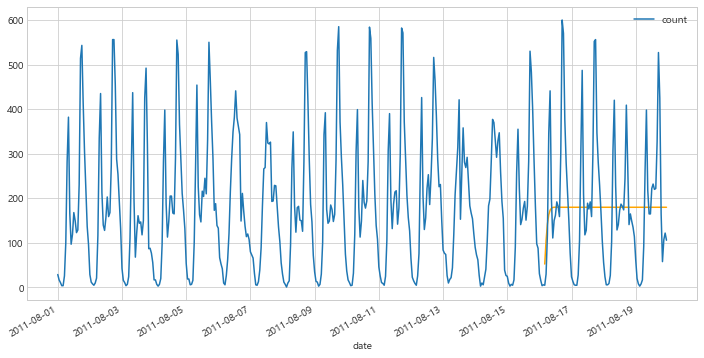

In [122]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(test_data.index, prediction, color='orange', label='Prediction')

data.plot(ax=ax);
plt.show()

In [123]:
mean_squared_error(test_data, prediction)

20979.468639215454

In [125]:
mae = mean_absolute_error(test_data, prediction)
mae

108.09912524083343

계절성 반영 시 SARIMA 모델링

In [126]:
print("Examples of parameter combinations for Seasoanal ARIMA...")
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in itertools.product(p,d,q)]
seasonal_pdq

Examples of parameter combinations for Seasoanal ARIMA...


[(0, 1, 0, 7),
 (0, 1, 1, 7),
 (0, 1, 2, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7),
 (1, 1, 2, 7),
 (2, 1, 0, 7),
 (2, 1, 1, 7),
 (2, 1, 2, 7)]

In [127]:
aic = []
params = []

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA : {i}{j} >> AIC : {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i,j))
            
        except:
            continue

SARIMA : (0, 1, 0)(0, 1, 0, 7) >> AIC : 4572.25
SARIMA : (0, 1, 0)(0, 1, 1, 7) >> AIC : 4261.5
SARIMA : (0, 1, 0)(0, 1, 2, 7) >> AIC : 4236.78
SARIMA : (0, 1, 0)(1, 1, 0, 7) >> AIC : 4346.58
SARIMA : (0, 1, 0)(1, 1, 1, 7) >> AIC : 4230.88
SARIMA : (0, 1, 0)(1, 1, 2, 7) >> AIC : 4227.12
SARIMA : (0, 1, 0)(2, 1, 0, 7) >> AIC : 4324.8
SARIMA : (0, 1, 0)(2, 1, 1, 7) >> AIC : 4228.58
SARIMA : (0, 1, 0)(2, 1, 2, 7) >> AIC : 4228.98
SARIMA : (0, 1, 1)(0, 1, 0, 7) >> AIC : 4472.44
SARIMA : (0, 1, 1)(0, 1, 1, 7) >> AIC : 4197.85
SARIMA : (0, 1, 1)(0, 1, 2, 7) >> AIC : 4190.14
SARIMA : (0, 1, 1)(1, 1, 0, 7) >> AIC : 4286.48
SARIMA : (0, 1, 1)(1, 1, 1, 7) >> AIC : 4187.24
SARIMA : (0, 1, 1)(1, 1, 2, 7) >> AIC : 4196.09
SARIMA : (0, 1, 1)(2, 1, 0, 7) >> AIC : 4268.11
SARIMA : (0, 1, 1)(2, 1, 1, 7) >> AIC : 4182.24
SARIMA : (0, 1, 1)(2, 1, 2, 7) >> AIC : 4189.68
SARIMA : (0, 1, 2)(0, 1, 0, 7) >> AIC : 4474.17
SARIMA : (0, 1, 2)(0, 1, 1, 7) >> AIC : 4197.96
SARIMA : (0, 1, 2)(0, 1, 2, 7) >> AIC : 41

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 0)(2, 1, 2, 7) >> AIC : 4207.76
SARIMA : (1, 1, 1)(0, 1, 0, 7) >> AIC : 4474.34
SARIMA : (1, 1, 1)(0, 1, 1, 7) >> AIC : 4198.97
SARIMA : (1, 1, 1)(0, 1, 2, 7) >> AIC : 4190.22
SARIMA : (1, 1, 1)(1, 1, 0, 7) >> AIC : 4288.31
SARIMA : (1, 1, 1)(1, 1, 1, 7) >> AIC : 4187.32
SARIMA : (1, 1, 1)(1, 1, 2, 7) >> AIC : 4196.35
SARIMA : (1, 1, 1)(2, 1, 0, 7) >> AIC : 4270.07
SARIMA : (1, 1, 1)(2, 1, 1, 7) >> AIC : 4183.45
SARIMA : (1, 1, 1)(2, 1, 2, 7) >> AIC : 4189.44
SARIMA : (1, 1, 2)(0, 1, 0, 7) >> AIC : 4421.86
SARIMA : (1, 1, 2)(0, 1, 1, 7) >> AIC : 4150.66
SARIMA : (1, 1, 2)(0, 1, 2, 7) >> AIC : 4141.32
SARIMA : (1, 1, 2)(1, 1, 0, 7) >> AIC : 4287.23
SARIMA : (1, 1, 2)(1, 1, 1, 7) >> AIC : 4139.87


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2)(1, 1, 2, 7) >> AIC : 4141.33
SARIMA : (1, 1, 2)(2, 1, 0, 7) >> AIC : 4226.17
SARIMA : (1, 1, 2)(2, 1, 1, 7) >> AIC : 4140.72


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2)(2, 1, 2, 7) >> AIC : 4142.33
SARIMA : (2, 1, 0)(0, 1, 0, 7) >> AIC : 4449.53
SARIMA : (2, 1, 0)(0, 1, 1, 7) >> AIC : 4183.9
SARIMA : (2, 1, 0)(0, 1, 2, 7) >> AIC : 4177.57
SARIMA : (2, 1, 0)(1, 1, 0, 7) >> AIC : 4284.58
SARIMA : (2, 1, 0)(1, 1, 1, 7) >> AIC : 4175.94
SARIMA : (2, 1, 0)(1, 1, 2, 7) >> AIC : 4182.55
SARIMA : (2, 1, 0)(2, 1, 0, 7) >> AIC : 4256.46
SARIMA : (2, 1, 0)(2, 1, 1, 7) >> AIC : 4175.27


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 0)(2, 1, 2, 7) >> AIC : 4179.2
SARIMA : (2, 1, 1)(0, 1, 0, 7) >> AIC : 4450.49
SARIMA : (2, 1, 1)(0, 1, 1, 7) >> AIC : 4185.62
SARIMA : (2, 1, 1)(0, 1, 2, 7) >> AIC : 4145.43
SARIMA : (2, 1, 1)(1, 1, 0, 7) >> AIC : 4245.92
SARIMA : (2, 1, 1)(1, 1, 1, 7) >> AIC : 4142.92
SARIMA : (2, 1, 1)(1, 1, 2, 7) >> AIC : 4162.64


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(2, 1, 0, 7) >> AIC : 4220.79
SARIMA : (2, 1, 1)(2, 1, 1, 7) >> AIC : 4142.27
SARIMA : (2, 1, 1)(2, 1, 2, 7) >> AIC : 4142.98
SARIMA : (2, 1, 2)(0, 1, 0, 7) >> AIC : 4388.5


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(0, 1, 1, 7) >> AIC : 4181.84
SARIMA : (2, 1, 2)(0, 1, 2, 7) >> AIC : 4170.11


c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(1, 1, 0, 7) >> AIC : 4246.16
SARIMA : (2, 1, 2)(1, 1, 1, 7) >> AIC : 4165.27
SARIMA : (2, 1, 2)(1, 1, 2, 7) >> AIC : 4150.5
SARIMA : (2, 1, 2)(2, 1, 0, 7) >> AIC : 4253.74
SARIMA : (2, 1, 2)(2, 1, 1, 7) >> AIC : 4153.63
SARIMA : (2, 1, 2)(2, 1, 2, 7) >> AIC : 4139.82


In [128]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
optimal

[(((2, 1, 2), (2, 1, 2, 7)), 4139.82)]

In [129]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  364
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 7)   Log Likelihood               -2060.909
Date:                           Sun, 21 Aug 2022   AIC                           4139.819
Time:                                   17:03:13   BIC                           4174.693
Sample:                                        0   HQIC                          4153.691
                                           - 364                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9201      0.135      6.834      0.000       0.656       1.184
ar.L2         -0.2209      0.131     -1.682      0.092      -0.478       0.036
ma.L1         -0.6882      2.654     -0.259      0.795      -5.889       4.513
ma.L2         -0.3115      0.873     -0.357      0.721      -2.023       1.400
ar.S.L7       -0.6366      0.572     -1.112      0.266      -1.759       0.485
ar.S.L14      -0.0065      0.146     -0.045      0.964      -0.293       0.279
ma.S.L7       -0.5230      0.777     -0.674      0.501      -2.045       0.999
ma.S.L14      -0.4729      0.587     -0.806      0.420      -1.623       0.677
sigma2      5610.2944   1.45e+04      0.386      0.700   -2.29e+04    3.41e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               124.42
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.73
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
prediction = model_opt_fit.get_forecast(len(test_data))
prediction_value = prediction.predicted_mean
predict_index = list(test_data.index)
r2 = r2_score(test_data, prediction_value)

In [140]:
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]

c:\Users\wagar\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


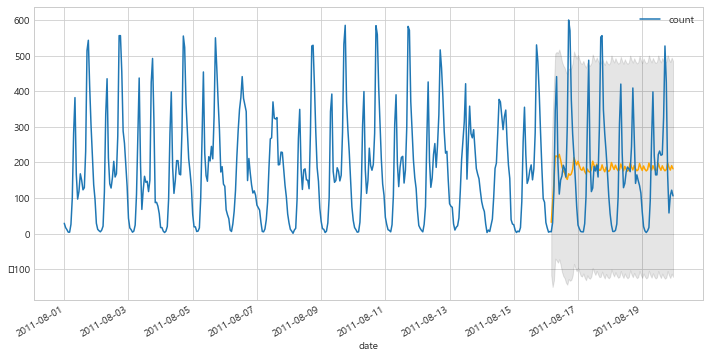

In [141]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(predict_index, prediction_value, color='orange', label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label = '0.95 Prediction')

data.plot(ax=ax)

plt.show()